In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

import sys


def setup_logging(
    epoch_key, date_format="%d-%b-%y %H:%M:%S", format="%(asctime)s %(message)s"
):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)


sns.set_context("talk")

In [3]:
epoch_key = ("david905", 1, 1)

In [4]:
setup_logging(epoch_key)

In [ ]:
logging.info("### Decoding Full Day ###")

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

03-Mar-21 11:20:39 Loading position information and linearizing...
03-Mar-21 11:21:07 Loading multiunits...


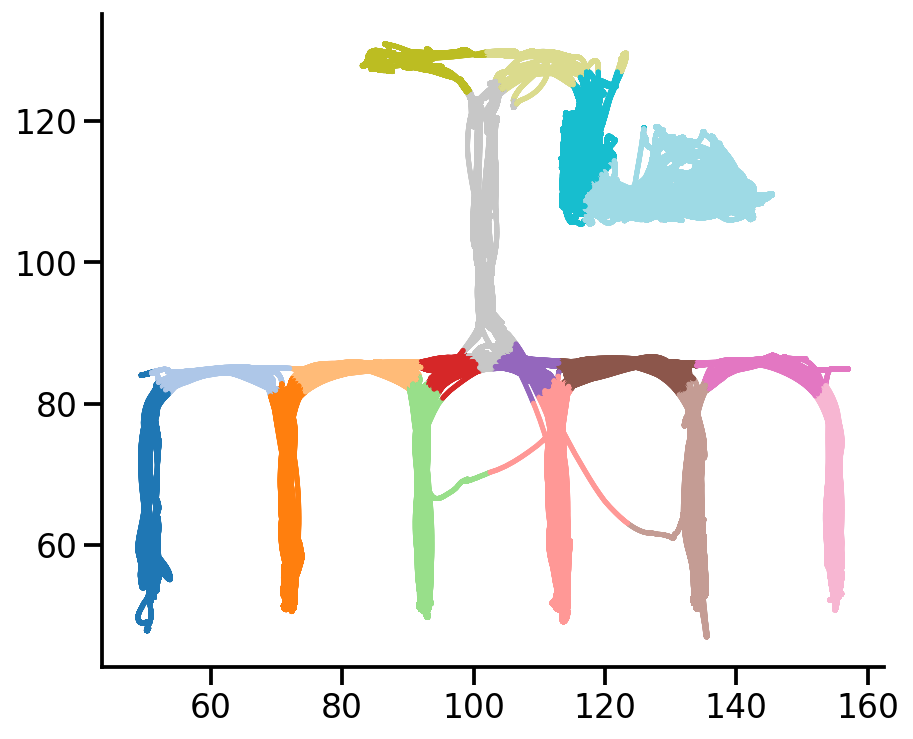

In [6]:
plt.figure(figsize=(7, 6))
plt.scatter(
    data["position_info"].x_position,
    data["position_info"].y_position,
    c=data["position_info"].track_segment_id,
    s=1,
    cmap="tab20",
)
sns.despine()

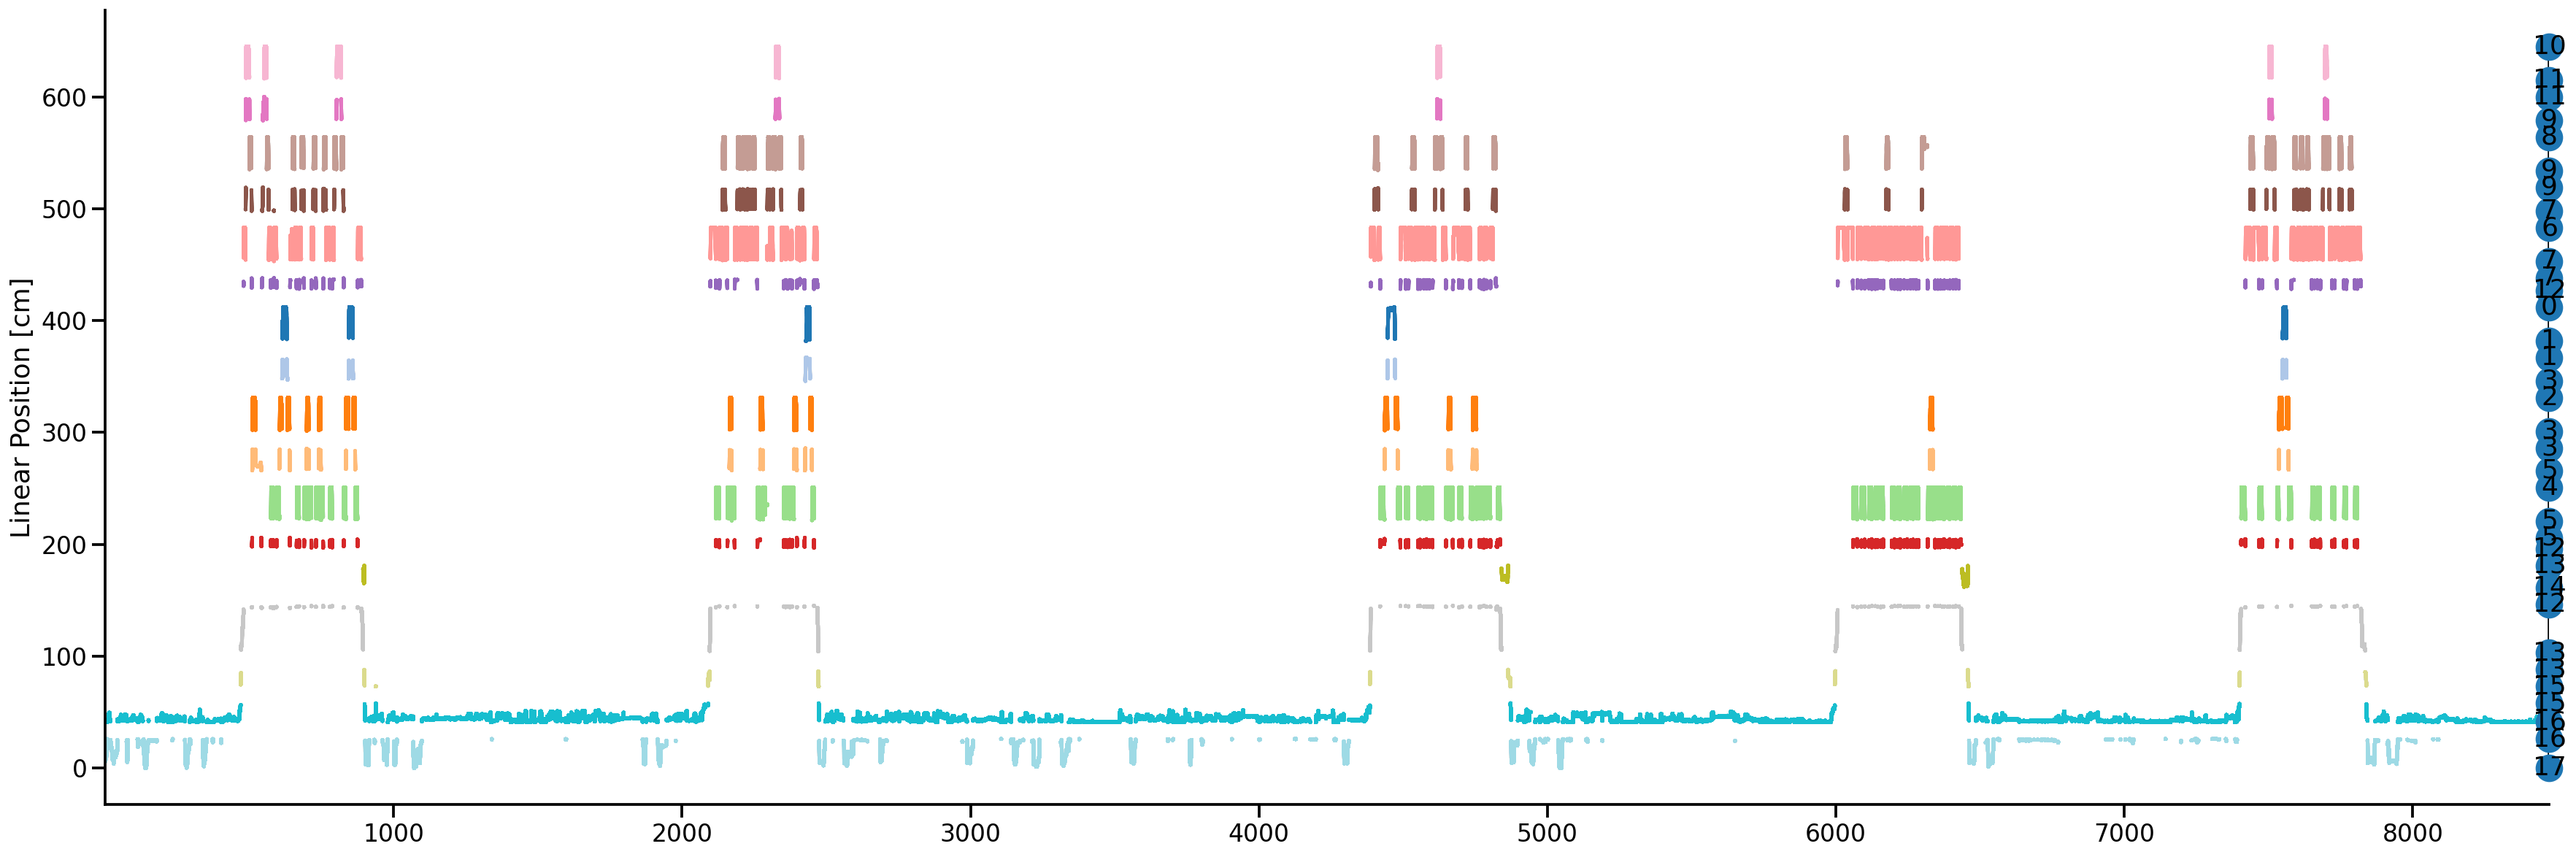

In [7]:
from src.parameters import EDGE_ORDER, EDGE_SPACING
from track_linearization import plot_graph_as_1D

plt.figure(figsize=(30, 10))

plt.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    c=data["position_info"].track_segment_id,
    cmap="tab20",
    s=1,
)
plot_graph_as_1D(
    data["track_graph"],
    EDGE_ORDER,
    EDGE_SPACING,
    axis="y",
    other_axis_start=data["position_info"].index[-1] / np.timedelta64(1, "s"),
)
plt.xlim(
    (
        data["position_info"].index[0] / np.timedelta64(1, "s"),
        data["position_info"].index[-1] / np.timedelta64(1, "s"),
    )
)
sns.despine()

In [8]:
continuous_transition_types = [["random_walk", "uniform"], ["uniform", "uniform"]]


classifier_parameters = {
    "movement_var": 6.0,
    "replay_speed": 1,
    "place_bin_size": 2.5,
    "continuous_transition_types": continuous_transition_types,
    "discrete_transition_diag": 0.968,
    "model_kwargs": {"bandwidth": np.array([20.0, 20.0, 20.0, 20.0, 8.0])},
}

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import PROCESSED_DATA_DIR
import os
from sklearn.model_selection import KFold

state_names = ['Continuous', 'Fragmented']
cv = KFold()
results = []

for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(**classifier_parameters)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunits"].isel(time=train),
        track_graph=data["track_graph"],
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )
    model_name = (f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_"
                  f"model_fold{fold_ind}.pkl")
    classifier.save_model(
        os.path.join(PROCESSED_DATA_DIR, model_name))

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunits"].isel(time=test),
            time=data["position_info"].iloc[test].index / np.timedelta64(1, "s"),
            state_names=state_names
        )
    )
    
# concatenate cv classifier results 
results = xr.concat(results, dim="time")
results_name = f"{epoch_key[0]}_{epoch_key[1]:02d}_{epoch_key[2]:02d}_results.nc"
results.to_netcdf(
    os.path.join(PROCESSED_DATA_DIR, results_name)
    )
logging.info('Done...\n\n')

03-Mar-21 11:23:01 Fitting Fold #1...
03-Mar-21 11:23:04 Fitting initial conditions...
03-Mar-21 11:23:04 Fitting state transition...
03-Mar-21 11:23:05 Fitting multiunits...
03-Mar-21 11:23:53 Predicting posterior...
